# Импорт библиотек

In [279]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import category_encoders as ce
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Чтение данных

In [280]:
raw_data = pd.read_csv('hotels.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Таблица включает 17 признаков, количество записей - 386803 строк. Есть пропуски в координатах. Помимо этого, есть пропуски в позитивных и негативных отзывах (пустые отзывы).

# Очистка данных и заполнение пропусков

In [281]:
raw_data_dedub = raw_data.drop_duplicates() # удаляем дубликаты
raw_data_dedub_filled = raw_data_dedub.fillna(0) # заполняем пропуски (это координаты) нулями для дальнейшей обработки

# создаем DF, где не указаны координаты
raw_data_short = raw_data_dedub_filled.drop(columns=[
    'additional_number_of_scoring',
    'review_date',
    'average_score',
    'reviewer_nationality',
    'negative_review',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'positive_review',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'reviewer_score',
    'hotel_name',
    'tags',
    'days_since_review'
    ])

raw_data_short = raw_data_short[(raw_data_short['lat']==0) | (raw_data_short['lng']==0)]
raw_data_short = raw_data_short.drop_duplicates()

# Функции для получения широты по адресу
def get_lat(adress):
    geolocator = Nominatim(user_agent="tastere")
    latitude = 0
    adress = adress.split(' ')
    for i in range(len(adress)): # Перебираем адрес от наиболее точного к более общему пока функция не определит широту
        adress_round = adress[i:]
        if geolocator.geocode(adress_round) is not None:
            latitude = geolocator.geocode(adress_round).latitude
            break
    return latitude

def get_lng(adress):
    geolocator = Nominatim(user_agent="tastere")
    longitude = 0
    adress = adress.split(' ')
    for i in range(len(adress)): # Перебираем адрес от наиболее точного к более общему пока функция не определит долготу
        adress_round = adress[i:]
        if geolocator.geocode(adress_round) is not None:
            longitude = geolocator.geocode(adress_round).longitude
            break
    return longitude


In [282]:
raw_data_short['lat'] = raw_data_short['hotel_address'].apply(get_lat) # функция работает довольно долго, поэтому вынесена в отдельную ячейку (более быстрого решения не смог найти)

In [283]:
raw_data_short['lng'] = raw_data_short['hotel_address'].apply(get_lng) # функция работает довольно долго, поэтому вынесена в отдельную ячейку (более быстрого решения не смог найти)

In [284]:
# заполнение пропусков координат в основной таблице
data_draft = raw_data_dedub_filled.merge(raw_data_short, on='hotel_address', suffixes=('', '_cur'), how='left') # объединяем основную таблицу и таблицу с информацией о координатах

# функция заполняет пропуск широты в основной таблице
def get_final_lat(df):
    lat = df['lat']
    if lat == 0: lat = df['lat_cur']
    return lat

# функция заполняет пропуск долготы в основной таблице
def get_final_lng(df):
    lng = df['lng']
    if lng == 0: lng = df['lng_cur']
    return lng

data_draft['lat'] = data_draft.loc[:, ['lat', 'lat_cur']].apply(get_final_lat, axis=1)
data_draft['lng'] = data_draft.loc[:, ['lng', 'lng_cur']].apply(get_final_lng, axis=1)
data = data_draft.drop(columns=['lat_cur', 'lng_cur']) # сохраняем таблицу, в которой заполнены все данные

Координаты заполнены. Заполнять пропуски в отзывах не имеет смысла, т.к. этот признак будет обрабтываться, как строковые переменные.

# Проектирование признаков и их кодирование

In [285]:
# Признак отношения количества слов в позитивном отзыве к количеству слов в негативном.
data['pos_len_share'] = round(data['review_total_positive_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts']), 4)
data['pos_len_share'] = data['pos_len_share'].fillna(data['pos_len_share'].median())

In [286]:
# Создаем признак страны
data['country']=data['hotel_address'].apply(lambda x: x.split(' ')[-1]) # последнее слово - страна, выделяем
print('Страны')
data['country'].value_counts() # смотрим результат, всего 6 стран, в Великобритании два слова

Kingdom        196773
Spain           45132
France          44528
Netherlands     43004
Austria         29177
Italy           27882
Name: country, dtype: int64

In [287]:
data['country'] = data['country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x) # исправляем название Великобритании
print('Страны')
data['country'].value_counts()

United Kingdom    196773
Spain              45132
France             44528
Netherlands        43004
Austria            29177
Italy              27882
Name: country, dtype: int64

Всего в DF 6 стран, большинство посещений приходится на Великобританию.

In [288]:
# Создаем признак города
data['city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2] if x.split(' ')[-1] != 'Kingdom' else x.split(' ')[-5]) # выгружаем название города с учетом, что для Великобритании немного отличается формат адреса
print('Города')
display(data['city'].value_counts())

London       196773
Barcelona     45132
Paris         44528
Amsterdam     43004
Vienna        29177
Milan         27882
Name: city, dtype: int64

Распределение по городам идентично распределению по странам, где они находятся, т.к. из каждой страны представлен только один город.

In [289]:
# Создаем признаки попадания отеля в центр своего города и расстояние от центра города. Создание признака займет несколько этапов.

# Создаем DF с данными о городах
geolocator = Nominatim(user_agent="tastere")
cities_info = {
    'city':['London', 'Barcelona', 'Paris', 'Amsterdam', 'Vienna', 'Milan'],
    'city_lat':[
        geolocator.geocode('London').latitude,
        geolocator.geocode('Barcelona').latitude,
        geolocator.geocode('Paris').latitude,
        geolocator.geocode('Amsterdam').latitude,
        geolocator.geocode('Vienna').latitude,
        geolocator.geocode('Milan').latitude
        ], # широта городов
    'city_lng':[
        geolocator.geocode('London').longitude,
        geolocator.geocode('Barcelona').longitude,
        geolocator.geocode('Paris').longitude,
        geolocator.geocode('Amsterdam').longitude,
        geolocator.geocode('Vienna').longitude,
        geolocator.geocode('Milan').longitude
        ], # долгота городов
    'length':[45, 15, 10, 14, 21, 17], # протяженность городов с севера на юг
    'width':[53, 6, 18, 15, 20, 15] # протяженность городов с востока на запад
}

cities_info = pd.DataFrame(cities_info)
cities_info['lat_center_upper_bound'] = cities_info['city_lat'] + (cities_info['length']/6)/111 # к широте центра города добавляем 1/6 его протяженности с севера на юг и переводим в градусы
cities_info['lat_center_bottom_line'] = cities_info['city_lat'] - (cities_info['length']/6)/111 # от широты центра города убавляем 1/6 его протяженности с севера на юг и переводим в градусы
cities_info['lng_center_upper_bound'] = cities_info['city_lng'] + (cities_info['width']/6)/111 # к долготе центра города добавляем 1/6 его протяженности с востока на запад и переводим в градусы
cities_info['lng_center_bottom_line'] = cities_info['city_lng'] - (cities_info['width']/6)/111 # от долготы центра города убавляем 1/6 его протяженности с востока на запад и переводим в градусы

In [290]:
data = data.merge(cities_info, on='city', how='outer') # добавляем в основную таблицу информацию о координатах границ центра города

# Функция определяет попадание координат отеля в поле центра города
def get_center(df):
    center = 0
    if df['lat'] < df['lat_center_upper_bound'] and df['lat'] > df['lat_center_bottom_line'] \
        and df['lng'] < df['lng_center_upper_bound'] and df['lng'] > df['lng_center_bottom_line']:
            center = 1
    return center

data['center'] = data.loc[:, ['lat', 'lat_center_upper_bound', 'lat_center_bottom_line', 'lng', 'lng_center_upper_bound', 'lng_center_bottom_line']].apply(get_center, axis=1)

# функция выводит расстояние отеля от центра города в километрах (работает долго)
def get_distance(df):
    distance = geodesic((df['lat'], df['lng']), (df['city_lat'], df['city_lng'])).kilometers
    return distance

data['center_distance'] = data.loc[:, ['lat', 'lng', 'city_lat', 'city_lng']].apply(get_distance, axis=1)

data = data.drop(columns=['lat_center_upper_bound', 'lat_center_bottom_line', 'lng_center_upper_bound', 'lng_center_bottom_line', 'city_lat', 'city_lng', 'length', 'width'])

Отель в центре города


1    257137
0    129359
Name: center, dtype: int64

<AxesSubplot: title={'center': 'Distance from the city center'}, ylabel='Frequency'>

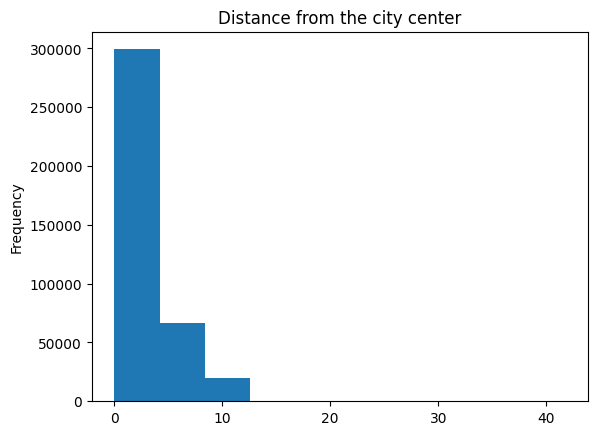

In [329]:
print('Отель в центре города')
display(data['center'].value_counts())

data['center_distance'].plot(kind='hist', title='Distance from the city center')

Примерно 2/3 отелей располагаются в центральной части города. С т.з. удаленности, подавляющее большинство отелей удалены от центра не более чем на 10 км. Распределение выглядит лог-нормальным, плюс скорее всего есть выбросы, ошибки и аномалии в этом признаке. Было принято решение их не очищать, т.к., во-первых, выбросы получится немного сгладить при нормализации признака, во-вторых, значимость признака оказалась не очень высокой и не хотелось терять более записи для работы с более значимыми признаками.

In [292]:
# Создаем признаки иностранного гостя и категории гражданства гостя
# Функция возвращает был ли гость иностранцем
def foreign_guest(df):
    if df['country'] in df['reviewer_nationality'] : return 1
    else: return 0

data['foreign_guest'] = data.loc[:, ['reviewer_nationality', 'country']].apply(foreign_guest, axis=1)

# Функция возвращает категорию гражданства гостя отеля
def get_nationality_type(nationality):
    if 'United Kingdom' in nationality: return 'United Kingdom'
    elif 'United States of America' in nationality: return 'United States of America'
    elif 'Australia' in nationality: return 'Australia'
    elif 'Ireland' in nationality: return 'Ireland'
    else: return 'other'

data['reviewer_nationality_type'] = data['reviewer_nationality'].apply(get_nationality_type)

In [293]:
print('Гость-иностранец')
display(data['foreign_guest'].value_counts())

print('Гражданство гостей')
display(data['reviewer_nationality_type'].value_counts())

0    252574
1    133922
Name: foreign_guest, dtype: int64

United Kingdom              183952
other                       148715
United States of America     26494
Australia                    16216
Ireland                      11119
Name: reviewer_nationality_type, dtype: int64

Треть гостей отелей были иностранцы. В структуре всех гостей наибольшую долю составляли граждане Великобритании (48%). На граждан США, Австралии и Ирландии приходилось по 7, 4 и 3% соответственно.38% гостей были гражданами других государств.

In [294]:
top_hotels = ['Marriott', 'Hilton', 'Hyatt', 'Ritz', 'Banyan', 'Four Seasons', 'Rixos', 'Sheraton', 'Mandarin', 'InterContinental', 'Radisson']

# Функция проверяет попадание отеля в список крупных отельных сетей
def get_top_hotel(name):
    for chain in top_hotels:
        if chain in name : return 1
    else: return 0

data['top_hotel'] = data['hotel_name'].apply(get_top_hotel)

In [295]:
print('Крупнейшие сети')
display(data['top_hotel'].value_counts())

0    343261
1     43235
Name: top_hotel, dtype: int64

Выборка представлена в основном небольшими сетями или самостоятельными отелями. Доля крупнейших  сетей отелей составляет 11%.

In [296]:
# Функция определяет отзывы без негатива
def get_no_negative(review):
    if 'nonegative' in review.replace(' ', '').lower() or 'nothing' in review.replace(' ', '').lower() or 'na' in review.replace(' ', '').lower(): return 1 # проверить с пропусками  or review == ' '
    else: return 0

data['no_negative'] = data['negative_review'].apply(get_no_negative)

In [297]:
print('Без негатива')
display(data['no_negative'].value_counts())

0    205349
1    181147
Name: no_negative, dtype: int64

В 47% отзывов было указано отсутствие негативных впечатлений.

In [298]:
# Функция определяет отзывы без позитива
def get_no_positive(review):
    if 'nopositive' in review.replace(' ', '').lower() or 'nothing' in review.replace(' ', '').lower() or 'na' in review.replace(' ', '').lower(): return 1 # проверить с пропусками  or review == ' '
    else: return 0

data['no_positive'] = data['positive_review'].apply(get_no_positive)

In [299]:
print('Без позитива')
display(data['no_positive'].value_counts())

0    265582
1    120914
Name: no_positive, dtype: int64

В 31% отзывов было указано отсутствие позитивных впечатлений.

In [300]:
data['leisure'] = data['tags'].apply(lambda x: 1 if 'Leisure' in x else 0) # 1 - отпуск, 0 - командировка
data['mobile_device'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0) # 1 - отправлено с мобильного устройства, 0 - другое

# Функция определяет тип группы, в составе которой гость посетил отель
def get_guest_group(tag):
    if 'Couple' in tag: return 'Couple'
    if 'Solo' in tag: return 'Solo'
    if 'Family' in tag: return 'Family'
    if 'Group' in tag: return 'Group'
    if 'Travelers with friends' in tag: return 'Travelers with friends'

data['guest_group'] = data['tags'].apply(get_guest_group)

In [301]:
print('Цель поездки')
display(data['leisure'].value_counts())

print('Тип устройства')
display(data['mobile_device'].value_counts())

print('Формат поездки')
display(data['guest_group'].value_counts())

1    313362
0     73134
Name: leisure, dtype: int64

1    230608
0    155888
Name: mobile_device, dtype: int64

Couple                    189046
Solo                       81166
Family                     66406
Group                      48269
Travelers with friends      1609
Name: guest_group, dtype: int64

В 81% наблюдений целью поездки был отдых. В остальных случаях - командировка.
В основном отзывы оставляли с мобильных устройств (60%). В остальных случаях тип устройства не был указан.
Преимущественно гости путешествовали парой (49%), реже одни или с семьей (21 и 17% соответственно). Путешествия в составе группы или с друзьями составляли 11 и 1% соответственно.

In [302]:
# Функция возвращает количество ночей, проведенных в отеле
def get_night_quantity(tag):
    for i in range(20):
        if f'Stayed {i+1}' in tag:
            return int(i+1)
            break
        
data['night_quantity'] = data['tags'].apply(get_night_quantity)
data['night_quantity'] = data['night_quantity'].fillna(data['night_quantity'].median())
data['night_quantity'] = data['night_quantity'].astype(int)

In [303]:
print('Количество ночей')
display(data['night_quantity'].value_counts())

1    147037
2    100407
3     71950
4     35708
5     15592
6      7388
7      5541
8      1907
9       966
Name: night_quantity, dtype: int64

В 38% случаев гости останавливались в отелях на одну ночь, далее идет постепенное убывание до 9 ночей.

In [304]:
# Функция возвращает категорию номера
def get_room_type(tag):
    if 'superior' in tag.lower(): return 'superior'
    elif 'deluxe' in tag.lower(): return 'deluxe'
    elif 'royal' in tag.lower(): return 'royal'
    elif 'executive' in tag.lower(): return 'executive'
    else: return 'standerd'
    

data['room_type'] = data['tags'].apply(get_room_type)

In [305]:
print('Тип номера')
display(data['room_type'].value_counts())

standerd     258537
superior      64585
deluxe        48862
executive     14291
royal           221
Name: room_type, dtype: int64

В основном гости останавливались в номерах катеогрии "стандарт" (69%). На посещения номеров "superior" и "deluxe" приходилось 17 и 13% соответственно.

In [306]:
good_word_list = [
    'accomplished',
    'adept',
    'amazing',
    'amiable',
    'awesome',
    'beautiful',
    'brilliant',
    'charming',
    'cheerful',
    'comfortable',
    'convenience',
    'elegant',
    'excellent',
    'extremely',
    'fabulous',
    'fantastic',
    'friendly',
    'gentle',
    'great',
    'good',
    'gorgeous',
    'helpful',
    'incredible',
    'lovely',
    'magnificent',
    'marvelous',
    'nice',
    'perfect',
    'pleasant',
    'polite',
    'positive',
    'pure',
    'romantic',
    'spectacular',
    'spacious',
    'super',
    'very',
    'wonderful'
    ]

bad_word_list = [
    'abhorrent',
    'absent',
    'abusive',
    'aggressive',
    'angry',
    'annoying',
    'awkward',
    'bad',
    'boring',
    'broken',
    'crowd',
    'depress',
    'dirty',
    'disappoint',
    'disaster',
    'disgusting',
    'disturb',
    'dust',
    'comfortable',
    'convenience',
    'empty',
    'extremely',
    'fail',
    'fraud',
    'glum',
    'harmful',
    'horrible',
    'inconvenience',
    'ill',
    'llegal',
    'impolite',
    'jagged',
    'lack',
    'monstrous',
    'negative',
    'nervous',
    'noise',
    'odd',
    'old',
    'poor',
    'rough',
    'rusty',
    'rude',
    'silly',
    'too',
    'ugly',
    'uncomfortable',
    'untidy',
    'useless',
    'very'
    ]

def good_word_count(review):
    count = 0
    for word in good_word_list:
        if word in review.lower(): count += 1
    return count

def bad_word_count(review):
    count = 0
    for word in good_word_list:
        if word in review.lower(): count += 1
    return count

data['good_word_count'] = data['positive_review'].apply(good_word_count)
data['bad_word_count'] = data['negative_review'].apply(bad_word_count)
data['bad_word_share'] = data['bad_word_count'] / (data['bad_word_count'] + data['good_word_count'])
data['good_word_share'] = data['good_word_count'] / (data['bad_word_count'] + data['good_word_count'])
data['bad_word_share'] = data['bad_word_share'].fillna(data['bad_word_share'].median())
data['good_word_share'] = data['good_word_share'].fillna(data['good_word_share'].median())

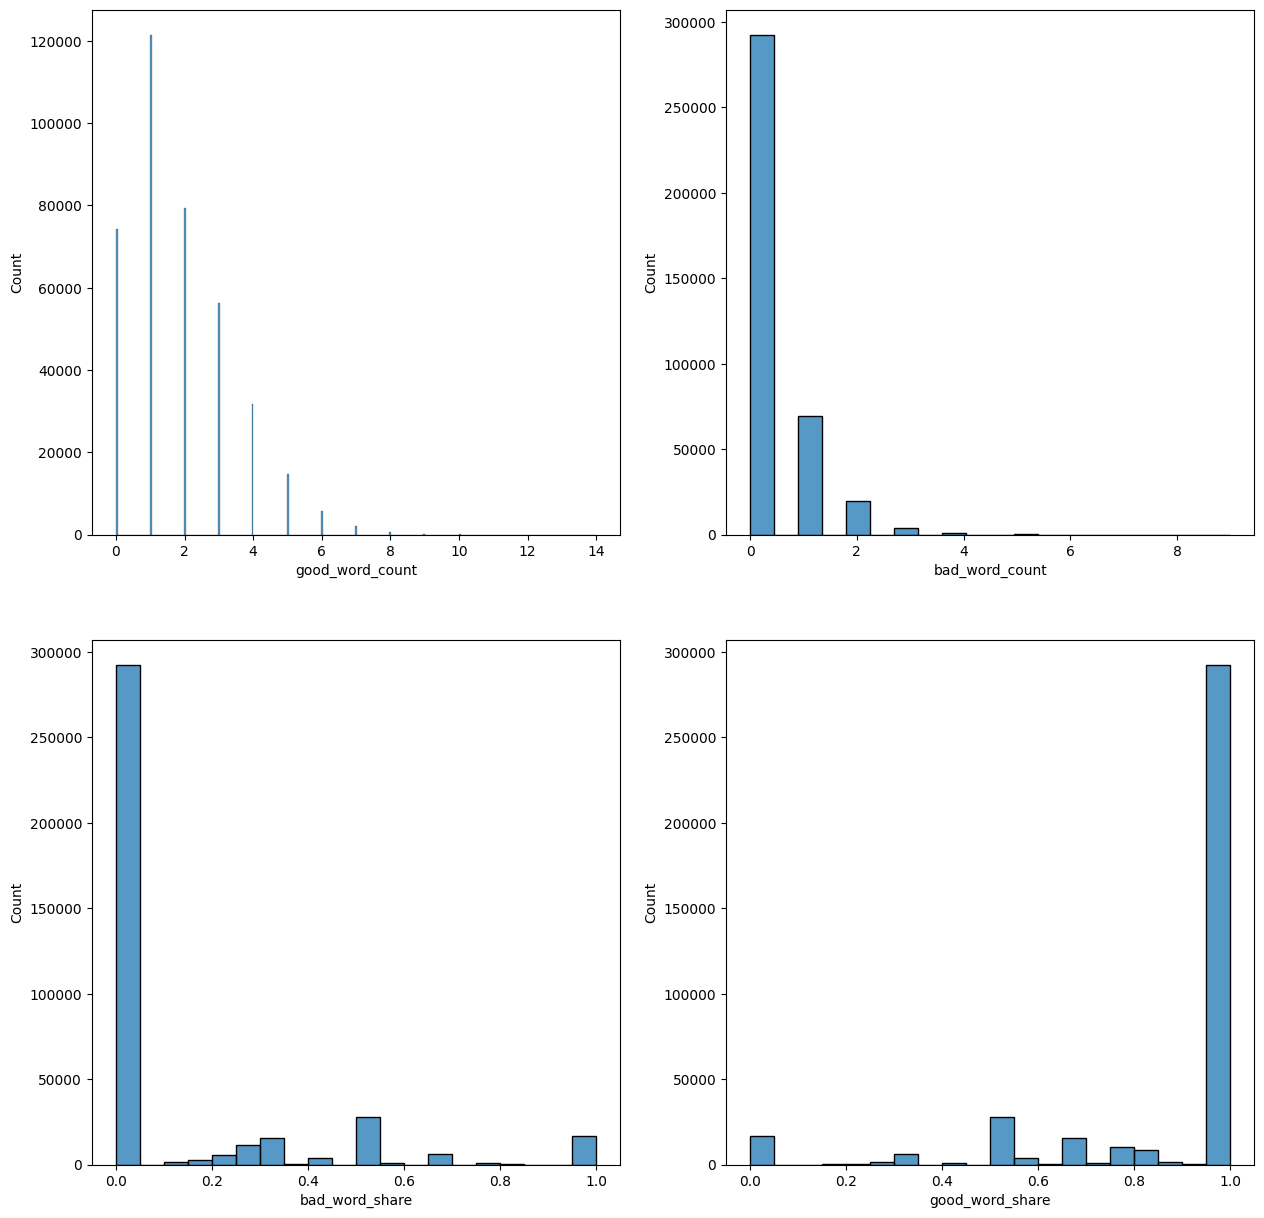

In [325]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

ax[0][0] = sns.histplot(data['good_word_count'], ax=ax[0][0], label ='good_word_count')
ax[0][1] = sns.histplot(data['bad_word_count'], ax=ax[0][1], label ='bad_word_count')
ax[1][0] = sns.histplot(data['bad_word_share'], ax=ax[1][0], label ='bad_word_share')
ax[1][1] = sns.histplot(data['good_word_share'], ax=ax[1][1], label ='good_word_share')

В своих позитивных отзывах гости чаще всего упортебляют 1-2 слова из списка позитивных слов, реже вообще не используют слова из этой категории. В плохих отзывах чаще гости избегаю слов из списка негативных по смыслу слов. Графики с долями позитивных и негативных слов в общей сумме таких слов вотзыве показывют, что люди используют позитивные эпитеты при описании своего опыта в отеле, но полностью избекают негативных слов.

In [308]:
data['days_since_review_nom'] = data['days_since_review'].apply(lambda x: x.replace(' day', '').replace('s', '')) # переводим из строки в число
data['days_since_review_nom'] = data['days_since_review_nom'].astype(int)

data['review_date'] = pd.to_datetime(data['review_date'])
data['weekday'] = pd.to_datetime(data['review_date']).dt.weekday # указываем день недели, кога оставлен отзыв
data['month'] = pd.to_datetime(data['review_date']).dt.month # казываем месяц, когда оставлен отзыв

# Функция возвращает номер сезона, когда оставлен отзыв: 1 - весна, 2 - лето, 3 - осень, 4 - зима
def get_season(month):
    if month >= 3 and month < 6: return 'spring'
    elif month >= 6 and month < 9: return 'summer'
    elif month >= 9 and month < 12: return 'automne'
    else: return 'winter'

data['season'] = data['month'].apply(get_season)
data['weekend'] = data['weekday'].apply(lambda x: 1 if x in [4, 5, 6] else 0)

In [309]:
print('Дни недели')
display(data['weekday'].value_counts())

print('Месяцыа')
display(data['month'].value_counts())

print('Времена года')
display(data['season'].value_counts())

print('Weekend')
display(data['weekend'].value_counts())

1    90888
6    62991
0    60679
3    55804
2    43823
5    38895
4    33416
Name: weekday, dtype: int64

8     37871
7     37114
5     34664
10    32932
6     32207
4     32202
9     31739
1     31494
3     30881
12    29697
2     28717
11    26978
Name: month, dtype: int64

summer     107192
spring      97747
automne     91649
winter      89908
Name: season, dtype: int64

0    251194
1    135302
Name: weekend, dtype: int64

Отзывы преимущественно оставлялись в воскресенье, понедельник и вторник, при этом распределение по дням недели достаточно равномерное. На конец недели приходится 35% отзывов.
Распределение по месяцам, когда был оставлен отзыв, без каких-либо заметных всплесков, но летние месяцы приходится больше отзывов, чем в любой другой сезон.

In [310]:
data_coded = data
data_coded = data.drop(columns=['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'country', 'days_since_review'])
data_coded = pd.get_dummies(data_coded, columns=['guest_group', 'room_type', 'reviewer_nationality_type', 'city', 'season', 'weekday', 'month'])

In [311]:
data_coded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386495
Data columns (total 69 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   additional_number_of_scoring                        386496 non-null  int64  
 1   average_score                                       386496 non-null  float64
 2   review_total_negative_word_counts                   386496 non-null  int64  
 3   total_number_of_reviews                             386496 non-null  int64  
 4   review_total_positive_word_counts                   386496 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given          386496 non-null  int64  
 6   reviewer_score                                      386496 non-null  float64
 7   lat                                                 386496 non-null  float64
 8   lng                                                 386496 non-n

После удаления текстовых признаков и кодирования (дамми) ряда категориальных признаков DF включает в себя 69 признаков.

# Стандартизация и нормализация признаков

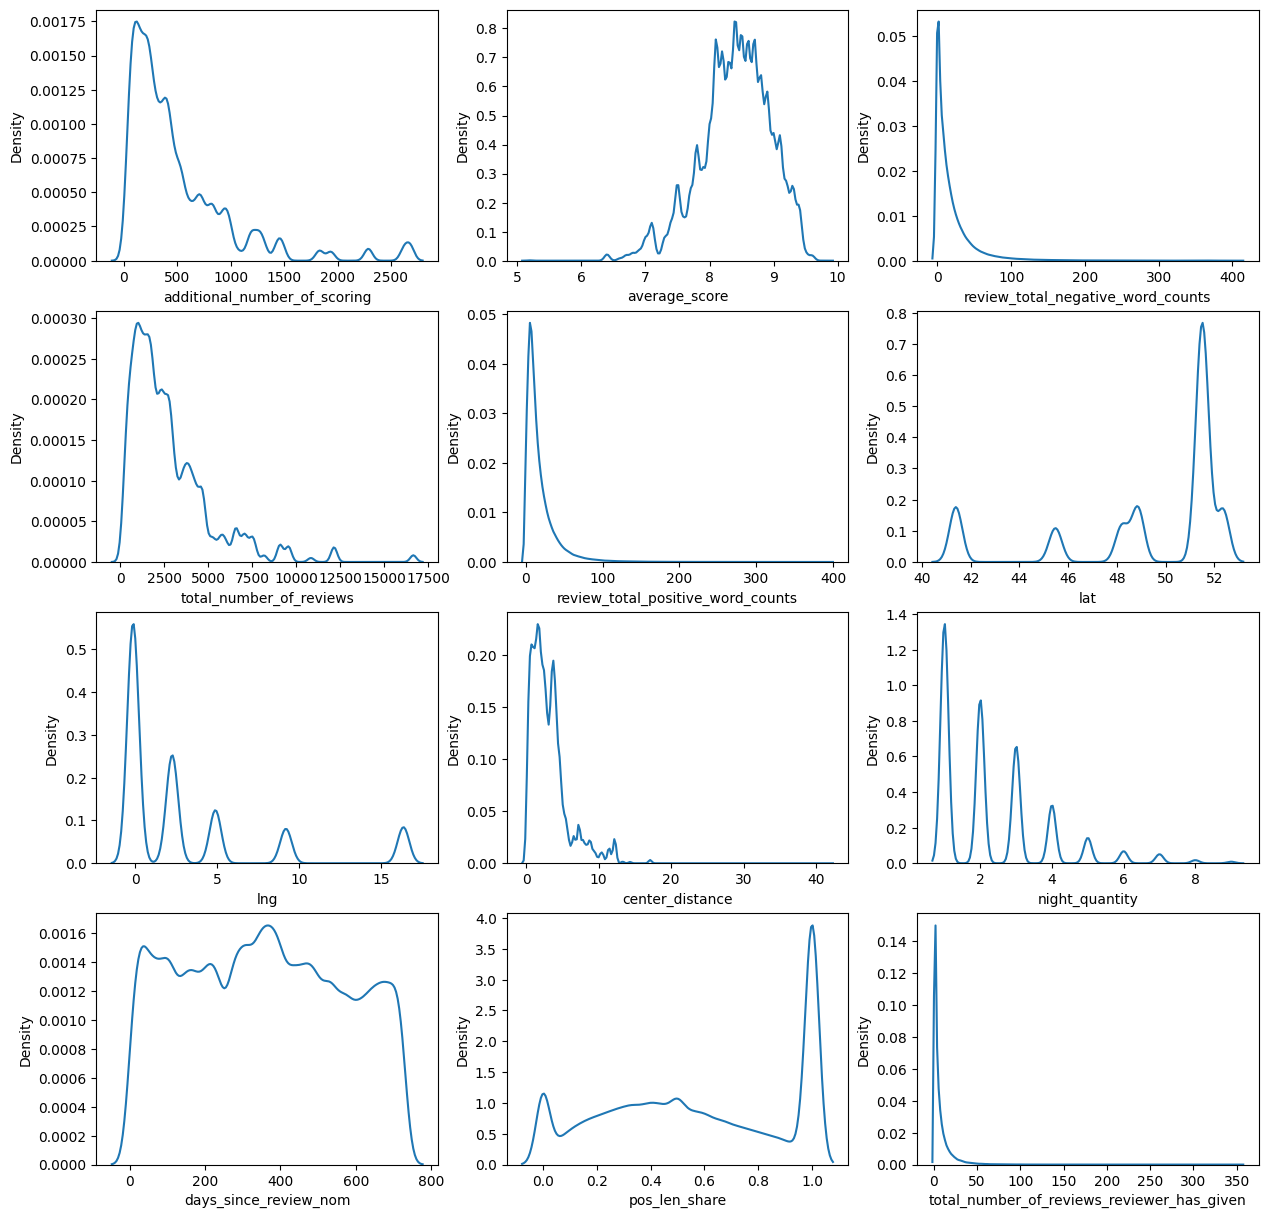

In [312]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

ax[0][0] = sns.kdeplot(data_coded['additional_number_of_scoring'], ax=ax[0][0], label ='additional_number_of_scoring')
ax[0][1] = sns.kdeplot(data_coded['average_score'], ax=ax[0][1], label ='average_score')
ax[0][2] = sns.kdeplot(data_coded['review_total_negative_word_counts'], ax=ax[0][2], label ='review_total_negative_word_counts')
ax[1][0] = sns.kdeplot(data_coded['total_number_of_reviews'], ax=ax[1][0], label ='total_number_of_reviews')
ax[1][1] = sns.kdeplot(data_coded['review_total_positive_word_counts'], ax=ax[1][1], label ='review_total_positive_word_counts')
ax[1][2] = sns.kdeplot(data_coded['lat'], ax=ax[1][2], label ='lat')
ax[2][0] = sns.kdeplot(data_coded['lng'], ax=ax[2][0], label ='lng')
ax[2][1] = sns.kdeplot(data_coded['center_distance'], ax=ax[2][1], label ='center_distance')
ax[2][2] = sns.kdeplot(data_coded['night_quantity'], ax=ax[2][2], label ='night_quantity')
ax[3][0] = sns.kdeplot(data_coded['days_since_review_nom'], ax=ax[3][0], label ='days_since_review_nom')
ax[3][1] = sns.kdeplot(data_coded['pos_len_share'], ax=ax[3][1], label ='pos_len_share')
ax[3][2] = sns.kdeplot(data_coded['total_number_of_reviews_reviewer_has_given'], ax=ax[3][2], label ='total_number_of_reviews_reviewer_has_given')

В боьшинстве факторов распределение лог-нормальное. Широта и долгота не явдяются показательными, полезная информация из этих признаков учтена в других факторах (город, удаленность от центра и попадание в центр города). Для нормализации значений целесообразно использовать метод RobustScaler, т.к. по ряду факторов есть выбросы.

In [313]:
r_scaler = preprocessing.RobustScaler()
data_coded['additional_number_of_scoring_norm'] = r_scaler.fit_transform(data_coded[['additional_number_of_scoring']])
data_coded['review_total_negative_word_counts_norm'] = r_scaler.fit_transform(data_coded[['review_total_negative_word_counts']])
data_coded['total_number_of_reviews_norm'] = r_scaler.fit_transform(data_coded[['total_number_of_reviews']])
data_coded['review_total_positive_word_counts_norm'] = r_scaler.fit_transform(data_coded[['review_total_positive_word_counts']])
data_coded['center_distance_norm'] = r_scaler.fit_transform(data_coded[['center_distance']])
data_coded['days_since_review_nom_norm'] = r_scaler.fit_transform(data_coded[['days_since_review_nom']])
data_coded['pos_len_share_norm'] = r_scaler.fit_transform(data_coded[['pos_len_share']])
data_coded['total_number_of_reviews_reviewer_has_given_norm'] = r_scaler.fit_transform(data_coded[['total_number_of_reviews_reviewer_has_given']])
data_coded['good_word_count_norm'] = r_scaler.fit_transform(data_coded[['good_word_count']])
data_coded['bad_word_count_norm'] = r_scaler.fit_transform(data_coded[['good_word_count']])
data_coded['good_word_share_norm'] = r_scaler.fit_transform(data_coded[['good_word_share']])
data_coded['bad_word_share_norm'] = r_scaler.fit_transform(data_coded[['bad_word_share']])

mm_scaler = preprocessing.MinMaxScaler()
data_coded['average_score_norm'] = mm_scaler.fit_transform(data_coded[['average_score']])
data_coded['night_quantity_norm'] = mm_scaler.fit_transform(data_coded[['night_quantity']])

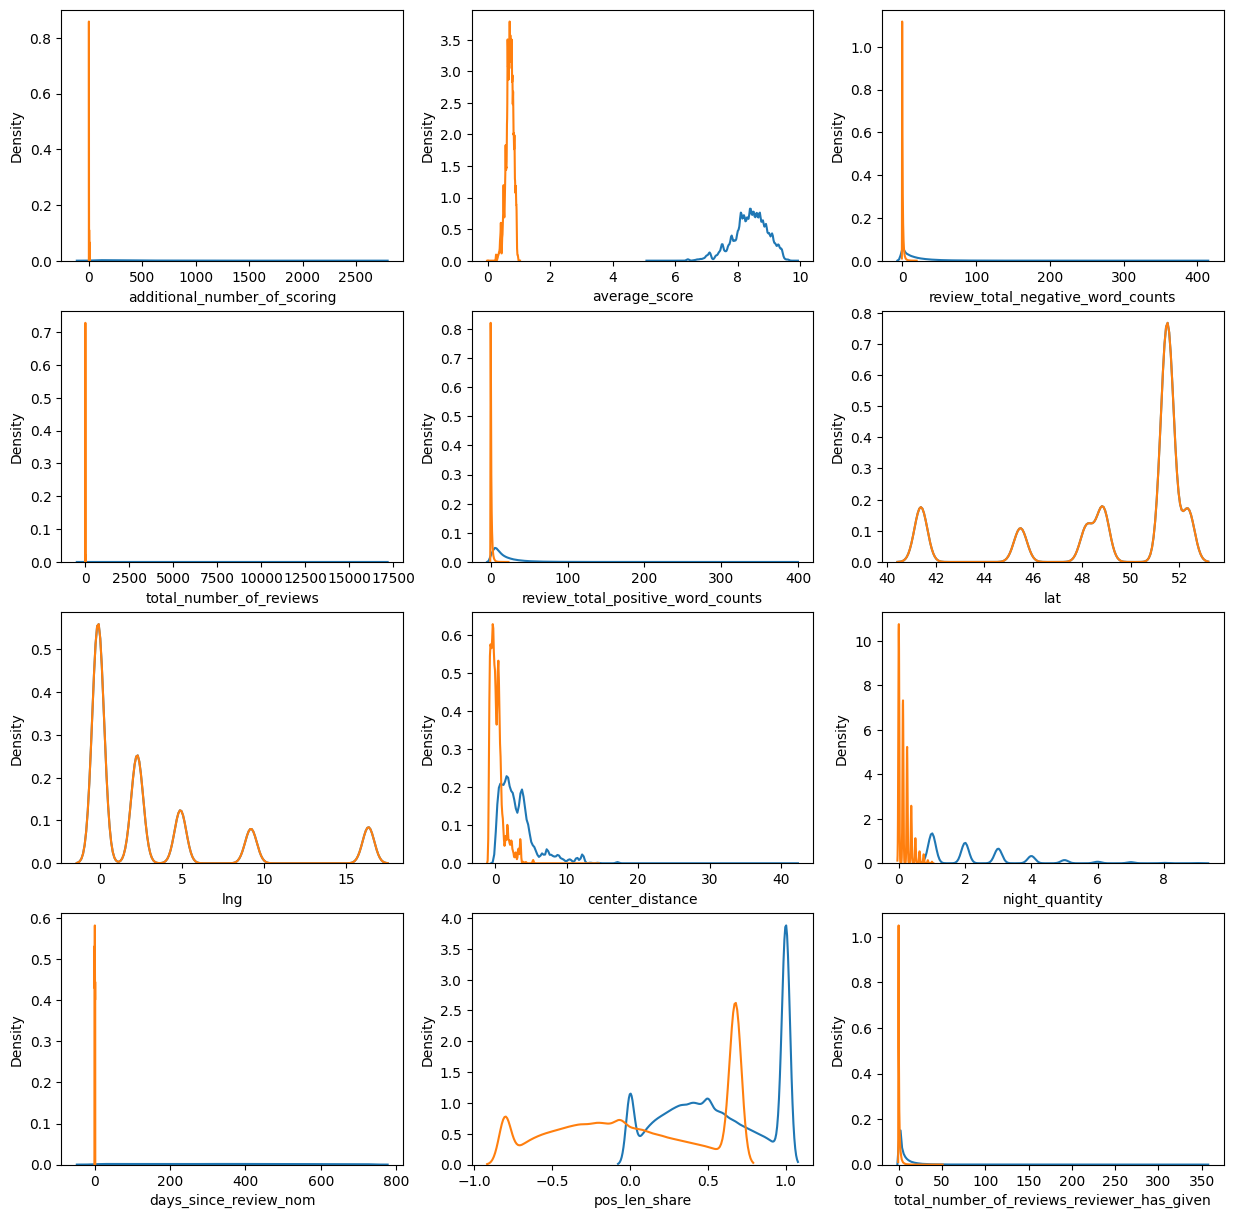

In [314]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

ax[0][0] = sns.kdeplot(data_coded['additional_number_of_scoring'], ax=ax[0][0], label ='additional_number_of_scoring')
ax[0][1] = sns.kdeplot(data_coded['average_score'], ax=ax[0][1], label ='average_score')
ax[0][2] = sns.kdeplot(data_coded['review_total_negative_word_counts'], ax=ax[0][2], label ='review_total_negative_word_counts')
ax[1][0] = sns.kdeplot(data_coded['total_number_of_reviews'], ax=ax[1][0], label ='total_number_of_reviews')
ax[1][1] = sns.kdeplot(data_coded['review_total_positive_word_counts'], ax=ax[1][1], label ='review_total_positive_word_counts')
ax[1][2] = sns.kdeplot(data_coded['lat'], ax=ax[1][2], label ='lat')
ax[2][0] = sns.kdeplot(data_coded['lng'], ax=ax[2][0], label ='lng')
ax[2][1] = sns.kdeplot(data_coded['center_distance'], ax=ax[2][1], label ='center_distance')
ax[2][2] = sns.kdeplot(data_coded['night_quantity'], ax=ax[2][2], label ='night_quantity')
ax[3][0] = sns.kdeplot(data_coded['days_since_review_nom'], ax=ax[3][0], label ='days_since_review_nom')
ax[3][1] = sns.kdeplot(data_coded['pos_len_share'], ax=ax[3][1], label ='pos_len_share')
ax[3][2] = sns.kdeplot(data_coded['total_number_of_reviews_reviewer_has_given'], ax=ax[3][2], label ='total_number_of_reviews_reviewer_has_given')

ax[0][0] = sns.kdeplot(data_coded['additional_number_of_scoring_norm'], ax=ax[0][0], label ='additional_number_of_scoring_norm')
ax[0][1] = sns.kdeplot(data_coded['average_score_norm'], ax=ax[0][1], label ='average_score_norm')
ax[0][2] = sns.kdeplot(data_coded['review_total_negative_word_counts_norm'], ax=ax[0][2], label ='review_total_negative_word_counts_norm')
ax[1][0] = sns.kdeplot(data_coded['total_number_of_reviews_norm'], ax=ax[1][0], label ='total_number_of_reviews_norm')
ax[1][1] = sns.kdeplot(data_coded['review_total_positive_word_counts_norm'], ax=ax[1][1], label ='review_total_positive_word_counts_norm')
ax[1][2] = sns.kdeplot(data_coded['lat'], ax=ax[1][2], label ='lat')
ax[2][0] = sns.kdeplot(data_coded['lng'], ax=ax[2][0], label ='lng')
ax[2][1] = sns.kdeplot(data_coded['center_distance_norm'], ax=ax[2][1], label ='center_distance_norm')
ax[2][2] = sns.kdeplot(data_coded['night_quantity_norm'], ax=ax[2][2], label ='night_quantity_norm')
ax[3][0] = sns.kdeplot(data_coded['days_since_review_nom_norm'], ax=ax[3][0], label ='days_since_review_nom_norm')
ax[3][1] = sns.kdeplot(data_coded['pos_len_share_norm'], ax=ax[3][1], label ='pos_len_share_norm')
ax[3][2] = sns.kdeplot(data_coded['total_number_of_reviews_reviewer_has_given_norm'], ax=ax[3][2], label ='total_number_of_reviews_reviewer_has_given_norm')

In [315]:
data_norm = data_coded.drop(columns=[
    'additional_number_of_scoring',
    'average_score',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'lat',
    'lng',
    'night_quantity',
    'days_since_review_nom_norm',
    'pos_len_share_norm',
    'total_number_of_reviews_reviewer_has_given',
    'center_distance',
    'bad_word_count',
    'good_word_count',
    'bad_word_share',
    'good_word_share'
    ])

# Отбор признаков

In [316]:
corr = data_norm.corr()
corr_list = []
for col in corr.columns:
    for row in corr.index:
        if col != row and abs(corr[col].loc[row]) > 0.7:
            corr_list.append([col, row, corr[col].loc[row]])

corr_list = pd.DataFrame(corr_list)
display (corr_list)

,0,1,2
0,foreign_guest,reviewer_nationality_type_United Kingdom,0.700053
1,reviewer_nationality_type_United Kingdom,foreign_guest,0.700053
2,reviewer_nationality_type_United Kingdom,reviewer_nationality_type_other,-0.753670
3,reviewer_nationality_type_other,reviewer_nationality_type_United Kingdom,-0.753670
4,additional_number_of_scoring_norm,total_number_of_reviews_norm,0.824494
5,total_number_of_reviews_norm,additional_number_of_scoring_norm,0.824494
6,good_word_count_norm,bad_word_count_norm,1.000000
7,bad_word_count_norm,good_word_count_norm,1.000000
8,good_word_share_norm,bad_word_share_norm,-1.000000
9,bad_word_share_norm,good_word_share_norm,-1.000000


Анализ выдал 5 пар высококоррелированных признаков. Удаляем те, с которыми модель показала более слабые результаты.

In [317]:
data_try = data_norm.drop(columns=[
    'reviewer_nationality_type_United Kingdom',
    'total_number_of_reviews_norm',
    'good_word_count_norm',
    'good_word_share_norm'
    ])

# Создание модели и расчет MAPE

In [318]:
# Создаем списки категориальных и количественных признаков
num_cols = ['total_number_of_reviews_reviewer_has_given_norm',
            'pos_len_share',
            'days_since_review_nom',
            'additional_number_of_scoring_norm',
            'review_total_negative_word_counts_norm',
            'review_total_positive_word_counts_norm',
            'center_distance_norm',
            'bad_word_count_norm',
            'bad_word_share_norm'
            ]

cat_cols = ['center',
            'foreign_guest',
            'top_hotel',
            'no_negative',
            'no_positive',
            'leisure',
            'mobile_device',
            'guest_group_Couple',
            'guest_group_Family',
            'guest_group_Group',
            'guest_group_Solo',
            'guest_group_Travelers with friends',
            'room_type_deluxe',
            'room_type_executive',
            'room_type_royal',
            'room_type_standerd',
            'room_type_superior',
            'reviewer_nationality_type_Australia',
            'reviewer_nationality_type_Ireland',
            'reviewer_nationality_type_United States of America',
            'reviewer_nationality_type_other',
            'city_Amsterdam',
            'city_Barcelona',
            'city_London',
            'city_Milan',
            'city_Paris',
            'city_Vienna',
            'season_automne',
            'season_spring',
            'season_summer',
            'season_winter',
            'average_score_norm',
            'night_quantity_norm',
            'weekend',
            'weekday_0',
            'weekday_1',
            'weekday_2',
            'weekday_3',
            'weekday_4',
            'weekday_5',
            'weekday_6',
            'month_1',
            'month_2',
            'month_3',
            'month_4',
            'month_5',
            'month_6',
            'month_7',
            'month_8',
            'month_9',
            'month_10',
            'month_11',
            'month_12'
            ]

In [319]:
# Параметры для модели
X = data_try.drop(['reviewer_score'], axis = 1)  
y = data_try['reviewer_score'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

<AxesSubplot: >

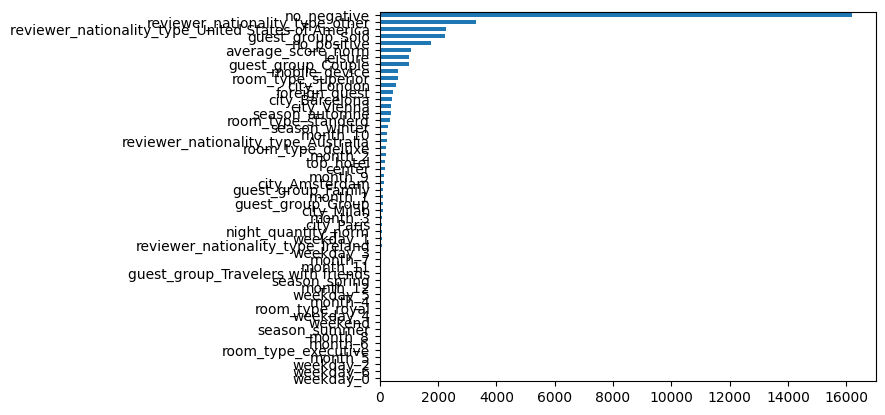

In [320]:
# Анализ начимости категориальных признаков
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Отсутствие негативного отзыва является самым главным признаком, далее идут гражданство (прочих стран и США), тип группы (самостоятельное путешествие) и т.д. Параметры, связанные со временем играют слабую роль, что логично, т.к. они привязаны к дате написания отзыва, а не дате посещения отеля.

<AxesSubplot: >

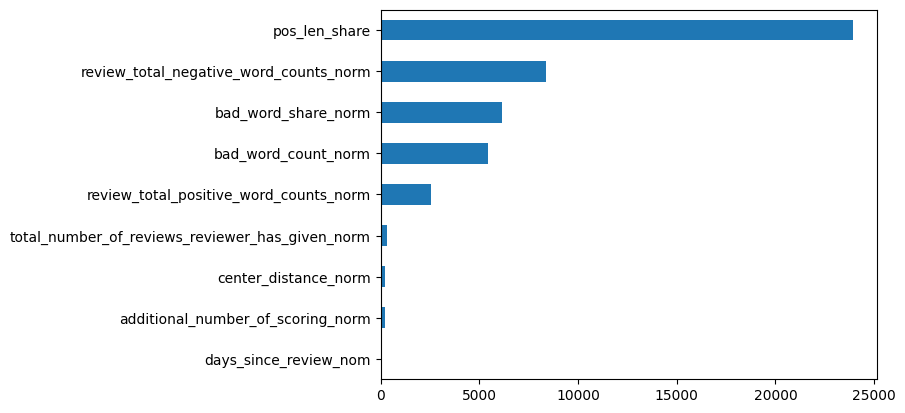

In [321]:
# Анализ начимости количественных признаков
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самый важный признак в этой группе - соотношение количества слов в позитивных и негативных отзывах, также количество слов в негативном отзыве, их доля в общем отзыве. Стоит обратить внимание, что почти все значимые признаки из обработки текста отзывов.

Далее по количеству признаков отбираем модель с наилучшим MAPE. По наблюдениям при снижении количества признаков MAPE постепенно возрастает. В задаче критерий качества модели определен как
MAPE < 13,5%. Мы установим это отсечение на уровне 12,9%.

In [326]:
threshold = 0.129
results = []
for i in range(data_try.shape[1]):
    X = data_try.drop(['reviewer_score'], axis = 1)  
    y = data_try['reviewer_score']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    select = SelectKBest(score_func=f_regression, k=data_try.shape[1]-i-1)
    z = select.fit_transform(X, y)
    
    filter = select.get_support()
    features = X.columns
    factors = features[filter]
    
    data_final = data_try[factors]
    
    X = data_final  
    y = data_try['reviewer_score']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    regr = RandomForestRegressor(n_estimators=100)     
    regr.fit(X_train, y_train)  
    y_pred = regr.predict(X_test)
    results.append([f"Selected best {data_try.shape[1]-i-1}:", metrics.mean_absolute_percentage_error(y_test, y_pred), factors])
    if metrics.mean_absolute_percentage_error(y_test, y_pred) > threshold: break
    print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
    print('')

MAPE: 0.12897560595199137

MAPE: 0.12893789605464478

MAPE: 0.12899292926239958

MAPE: 0.12898209232335506

MAPE: 0.12894047699450145



In [332]:
results = pd.DataFrame(results)
display(results)

,0,1,2
0,Selected best 62:,0.128976,"Index(['pos_len_share', 'center', 'foreign_gue..."
1,Selected best 61:,0.128938,"Index(['pos_len_share', 'center', 'foreign_gue..."
2,Selected best 60:,0.128993,"Index(['pos_len_share', 'center', 'foreign_gue..."
3,Selected best 59:,0.128982,"Index(['pos_len_share', 'center', 'foreign_gue..."
4,Selected best 58:,0.128940,"Index(['pos_len_share', 'center', 'foreign_gue..."
5,Selected best 57:,0.129039,"Index(['pos_len_share', 'center', 'foreign_gue..."


In [336]:
print('Итоговая модель включает в себя следующие признаки:')
display(results[2].iloc[1])

Index(['pos_len_share', 'center', 'foreign_guest', 'top_hotel', 'no_negative',
       'no_positive', 'leisure', 'mobile_device', 'days_since_review_nom',
       'weekend', 'guest_group_Couple', 'guest_group_Family',
       'guest_group_Group', 'guest_group_Solo',
       'guest_group_Travelers with friends', 'room_type_deluxe',
       'room_type_executive', 'room_type_royal', 'room_type_standerd',
       'room_type_superior', 'reviewer_nationality_type_Australia',
       'reviewer_nationality_type_Ireland',
       'reviewer_nationality_type_United States of America',
       'reviewer_nationality_type_other', 'city_Amsterdam', 'city_Barcelona',
       'city_London', 'city_Milan', 'city_Paris', 'city_Vienna',
       'season_automne', 'season_spring', 'season_summer', 'season_winter',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10'

Наилучший результат по MAPE показала модель, включающая в себя 61 признак. Итоговый показатель заметно лучше минимального порга 13,5% и составялет 12,89%.